In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import supervision as sv
from PIL import Image

In [2]:
model = YOLO("../models/obb-150ep.pt")


image 1/1 /home/mees/Desktop/UVA/Scriptie/License-Plate-Recognition-Thesis/test_notebooks/images/IMG_2064.jpg: 640x480 200.1ms
Speed: 6.5ms preprocess, 200.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


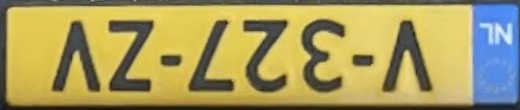

In [14]:
def crop_license_plate(img):
    results = model(img)


    detections = sv.Detections.from_ultralytics(results[0])
    xyxyxyxy = detections[0].data['xyxyxyxy'][0]

    point1, point2, point3, point4 = xyxyxyxy
    box_points = [point3, point2, point1, point4]

    # make blank image of size 520x110
    blank_image = np.zeros((110, 520, 3), np.uint8)
    blank_image[:] = (255, 255, 255)


    matrix = cv2.getPerspectiveTransform(np.array(box_points, dtype=np.float32), np.array([[0, 0], [520, 0], [520, 110], [0, 110]], dtype=np.float32))
    warped = cv2.warpPerspective(cv2.imread(img), matrix, (520, 110))

    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    warped = Image.fromarray(warped)

    return warped


crop_license_plate('images/IMG_2064.jpg')


In [40]:
img = crop_license_plate('images/IMG_2064.jpg')
img.save('processed_images/cropped.jpg')
img = cv2.imread('processed_images/cropped.jpg', cv2.IMREAD_GRAYSCALE)

kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

th, im_gray_th_otsu = cv2.threshold(closing, 128, 192, cv2.THRESH_OTSU)

cv2.imwrite('processed_images/processed.jpg', im_gray_th_otsu)



image 1/1 /home/mees/Desktop/UVA/Scriptie/License-Plate-Recognition-Thesis/test_notebooks/images/IMG_2064.jpg: 640x480 293.9ms
Speed: 8.1ms preprocess, 293.9ms inference, 8.8ms postprocess per image at shape (1, 3, 640, 480)


True

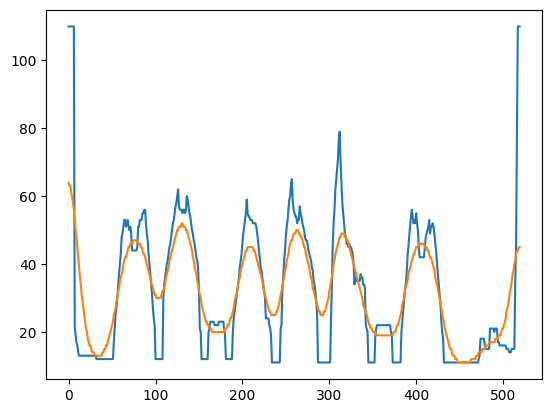

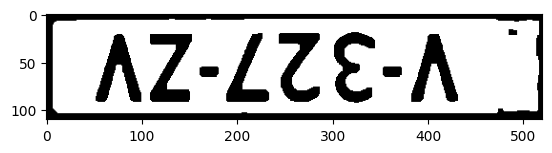

In [41]:
processed_img = cv2.imread('processed_images/processed.jpg')
# binarize the image
gray = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

cv2.imwrite('processed_images/binarized.jpg', binary)


black_pixels = []
for x in range(binary.shape[1]):
    black_pixels.append(np.sum(binary[:, x] == 0))

import matplotlib.pyplot as plt
plt.plot(black_pixels)

# smooth the graph
from scipy.ndimage import gaussian_filter1d
smoothed = gaussian_filter1d(black_pixels, sigma=10)
plt.plot(smoothed)
plt.show()

# also plot binary image
plt.figure()
plt.imshow(binary, cmap='gray')
plt.show()


